In [1]:
!pip install pandas numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-11-26'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981743   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831560   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172955   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519840   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-25 XYL     128.580002  128.940002  129.279999  126.120003  127.430000   
           YUM     136.389114  137.050003  138.649994  135.009995  136.229996   
           ZBH     110.959999  110.959999  111.860001  110.139999  110.709999   
           ZBRA    400.940002  400.940002  404.320007  398.130005  400.029999   
           ZTS     178.710007  178.710007  178.800003  176.149994  177.000000   

Price                   volume  
date       ticker               
2016-11-28 A         2241800.0  
           AAPL    108776000.0  
           ABBV      6274600.0  
           ABT       5727800.0  
           ACGL      1845000.0  
...                        ...  
2024-11-25 XYL       4258900.0  
           YUM       3604600.0  
           ZBH       2028400.0  
           ZBRA       420200.0  
           ZTS       4558300.0  

[989765 rows x 6 columns]

In [3]:
# Calculating features and technical indicators for each stock

# Garman-klass volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_up'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14
    )
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# MACD
def compute_macd(close):
    macd = pandas_ta.macd(
        close=close,
        length=20
    ).iloc[:, 0]
    
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Dollar volume
df['dollar_volume'] = df['adj close']*df['volume'] / 1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981743   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831560   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172955   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519840   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-25 XYL     128.580002  128.940002  129.279999  126.120003  127.430000   
           YUM     136.389114  137.050003  138.649994  135.009995  136.229996   
           ZBH     110.959999  110.959999  111.860001  110.139999  110.709999   
           ZBRA    400.940002  400.940002  404.320007  398.130005  400.029999   
           ZTS     178.710007  178.710007  178.800003  176.149994  177.000000   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-11-28 A         2241800.0         -0.002333        NaN       NaN   
           AAPL    108776000.0         -0.002156        NaN       NaN   
           ABBV      6274600.0         -0.043999        NaN       NaN   
           ABT       5727800.0         -0.009439        NaN       NaN   
           ACGL      1845000.0         -0.001127        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-25 XYL       4258900.0          0.000275  53.070987  4.780302   
           YUM       3604600.0          0.000353  55.725998  4.878118   
           ZBH       2028400.0          0.000118  55.802776  4.667584   
           ZBRA       420200.0          0.000117  62.622871  5.927813   
           ZTS       4558300.0          0.000076  47.244631  5.148636   

Price                bb_mid     bb_up       atr      macd  dollar_volume  
date       ticker                                                         
2016-11-28 A            NaN       NaN       NaN       NaN      91.872871  
           AAPL         NaN       NaN       NaN       NaN    2809.853785  
           ABBV         NaN       NaN       NaN       NaN     264.618421  
           ABT          NaN       NaN       NaN       NaN     191.994941  
           ACGL         NaN       NaN       NaN       NaN      47.731587  
...                     ...       ...       ...       ...            ...  
2024-11-25 XYL     4.825859  4.871416  0.686490 -0.883954     547.609370  
           YUM     4.903858  4.929598  0.822740 -0.069735     491.628202  
           ZBH     4.702971  4.738358 -0.620562  0.473989     225.071262  
           ZBRA    5.969854  6.011894  0.064628  0.592469     168.474989  
           ZTS     5.179616  5.210596  0.593702 -1.067643     814.613824  

[989765 rows x 14 columns]

In [4]:
# Aggregate monthly level and filter top 150 most liquid stocks for each month
# To reduce training time
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')
], axis=1)).dropna()

data

dollar_volume   adj close       atr    bb_low    bb_mid  \
date       ticker                                                            
2017-01-31 A          102.349487   46.162548 -1.382505  3.803595  3.833158   
           AAPL      3120.691390   28.095901 -1.447124  3.327728  3.356231   
           ABBV       344.889475   43.780579 -1.437684  3.779777  3.810983   
           ABT        371.924549   36.375008 -1.412520  3.557928  3.591215   
           ACGL        29.688113   28.003962 -1.171943  3.331300  3.355690   
...                          ...         ...       ...       ...       ...   
2024-11-30 XYL        223.297496  128.580002  0.686490  4.780302  4.825859   
           YUM        282.006739  136.389114  0.822740  4.878118  4.903858   
           ZBH        182.708239  110.959999 -0.620562  4.667584  4.702971   
           ZBRA       151.018153  400.940002  0.064628  5.927813  5.969854   
           ZTS        545.222028  178.710007  0.593702  5.148636  5.179616   

                      bb_up  garman_klass_vol      macd        rsi  
date       ticker                                                   
2017-01-31 A       3.862721         -0.000339  0.137243  61.726374  
           AAPL    3.384733         -0.002159 -0.131990  71.538080  
           ABBV    3.842188         -0.038072 -0.322890  49.986877  
           ABT     3.624503         -0.004523  0.188821  72.328321  
           ACGL    3.380080         -0.001044 -0.007918  61.679154  
...                     ...               ...       ...        ...  
2024-11-30 XYL     4.871416          0.000275 -0.883954  53.070987  
           YUM     4.929598          0.000353 -0.069735  55.725998  
           ZBH     4.738358          0.000118  0.473989  55.802776  
           ZBRA    6.011894          0.000117  0.592469  62.622871  
           ZTS     5.210596          0.000076 -1.067643  47.244631  

[46730 rows x 9 columns]

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr    bb_low    bb_mid     bb_up  \
date       ticker                                                       
2017-12-31 AAPL     39.811535 -1.257955  3.698682  3.724109  3.749536   
           ABBV     71.096016 -0.924179  4.253741  4.278529  4.303317   
           ABT      50.525513 -1.373460  3.884984  3.922018  3.959052   
           ACN     137.983643 -1.162646  4.891671  4.921786  4.951901   
           ADBE    175.240005 -1.354590  5.137116  5.167383  5.197650   
...                       ...       ...       ...       ...       ...   
2024-11-30 VZ       43.980000 -0.290661  3.708072  3.750640  3.793208   
           WFC      76.900002  1.731739  4.143007  4.268609  4.394211   
           WMT      89.500000  2.788531  4.393800  4.451076  4.508352   
           XOM     119.970001  0.446635  4.752672  4.787340  4.822008   
           ZTS     178.710007  0.593702  5.148636  5.179616  5.210596   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-12-31 AAPL           -0.001775 -0.269496  47.784577  
           ABBV           -0.039988  0.078596  55.000819  
           ABT            -0.006559  0.164477  59.877807  
           ACN            -0.004850  0.224529  65.003647  
           ADBE            0.000056 -0.179162  51.008416  
...                             ...       ...        ...  
2024-11-30 VZ              0.000061  0.314515  61.422770  
           WFC             0.000121  3.772380  75.610692  
           WMT             0.000173  3.005488  70.303700  
           XOM             0.000120  0.383641  52.597177  
           ZTS             0.000076 -1.067643  47.244631  

[12516 rows x 8 columns]

In [6]:
# Calculate monthly returns for diff time horizons
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
 
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr    bb_low    bb_mid     bb_up  \
date       ticker                                                       
2018-12-31 AAPL     37.665623 -0.672649  3.585046  3.697134  3.809221   
           ABBV     70.416031  0.746256  4.152361  4.223280  4.294199   
           ABT      65.209160  0.308162  4.111693  4.169437  4.227180   
           ACN     129.389038 -0.152084  4.807611  4.940240  5.072869   
           ADBE    226.240005 -0.043111  5.329066  5.452557  5.576047   
...                       ...       ...       ...       ...       ...   
2024-11-30 VRTX    461.709991  2.719661  6.087728  6.169130  6.250533   
           VZ       43.980000 -0.290661  3.708072  3.750640  3.793208   
           WFC      76.900002  1.731739  4.143007  4.268609  4.394211   
           WMT      89.500000  2.788531  4.393800  4.451076  4.508352   
           XOM     119.970001  0.446635  4.752672  4.787340  4.822008   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 AAPL           -0.000835 -1.246777  37.072865  -0.116698   
           ABBV           -0.026539 -0.101506  57.957337  -0.022064   
           ABT            -0.003189 -0.322493  55.190166  -0.023227   
           ACN            -0.002485 -1.467007  36.633821  -0.142901   
           ADBE            0.000161 -0.755420  46.330419  -0.098250   
...                             ...       ...        ...        ...   
2024-11-30 VRTX            0.000072 -1.823133  45.478326  -0.029980   
           VZ              0.000061  0.314515  61.422770   0.043912   
           WFC             0.000121  3.772380  75.610692   0.191360   
           WMT             0.000173  3.005488  70.303700   0.092129   
           XOM             0.000120  0.383641  52.597177   0.035758   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024292  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VRTX    -0.003630  -0.023525   0.002318   0.010378    0.022189  
           VZ      -0.002714   0.022519   0.016507   0.015919    0.016977  
           WFC      0.170105   0.097732   0.044782   0.038915    0.048741  
           WMT      0.052786   0.050378   0.053213   0.049291    0.043784  
           XOM      0.015810   0.008452   0.006530   0.018181    0.015839  

[10378 rows x 14 columns]

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142901
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-09-30 VRTX    0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.062131
           VZ      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.074916
           WFC     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.033863
           WMT     0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.045578
           XOM     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.006105

[10093 rows x 6 columns]

In [8]:
# stock with less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142901
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-09-30 VRTX    0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.062131
           VZ      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.074916
           WFC     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.033863
           WMT     0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.045578
           XOM     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.006105

[10062 rows x 6 columns]

In [9]:
## Rolling factor betas
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-09-30 VRTX    0.889386  0.612210 -0.156810  1.237733 -0.294761
           VZ      0.552558 -0.786406  0.382697 -0.053242 -0.092591
           WFC     1.108948 -0.147554  1.287193 -0.756867 -0.751741
           WMT     0.694615  0.017430 -0.189725  1.177724  0.066591
           XOM     0.627059 -0.088936  0.428996  0.793180  0.802819

[10062 rows x 5 columns]

In [10]:
# join them to the current features
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10114 entries, (Timestamp('2018-12-31 00:00:00', freq='M'), 'AAPL') to (Timestamp('2024-11-30 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10114 non-null  float64
 1   bb_low            10114 non-null  float64
 2   bb_mid            10114 non-null  float64
 3   bb_up             10114 non-null  float64
 4   garman_klass_vol  10114 non-null  float64
 5   macd              10114 non-null  float64
 6   rsi               10114 non-null  float64
 7   return_1m         10114 non-null  float64
 8   return_2m         10114 non-null  float64
 9   return_3m         10114 non-null  float64
 10  return_6m         10114 non-null  float64
 11  return_9m         10114 non-null  float64
 12  return_12m        10114 non-null  float64
 13  Mkt-RF            10114 non-null  float64
 14  SMB               10114 non-null  flo

In [13]:
# Applying K-means for each month to group similar assets based on their features
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

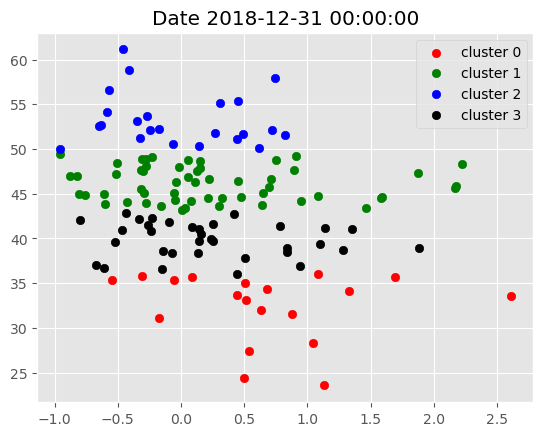

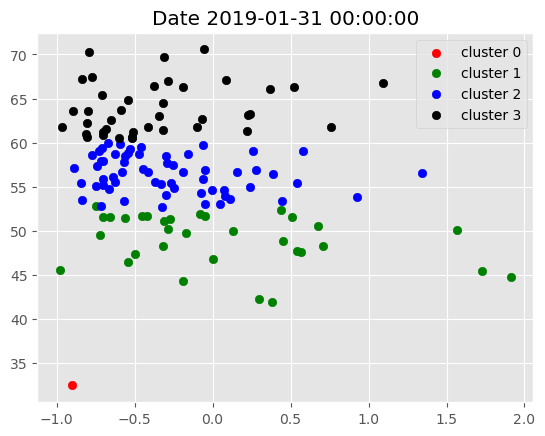

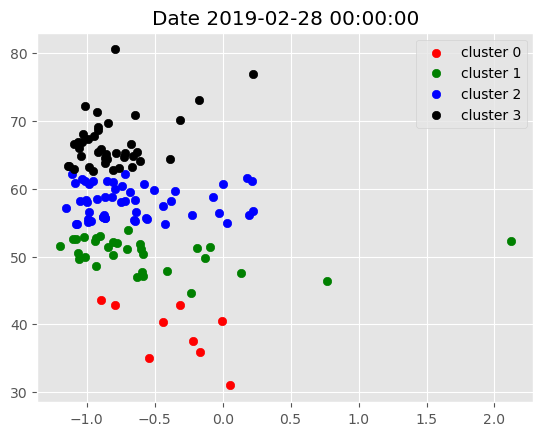

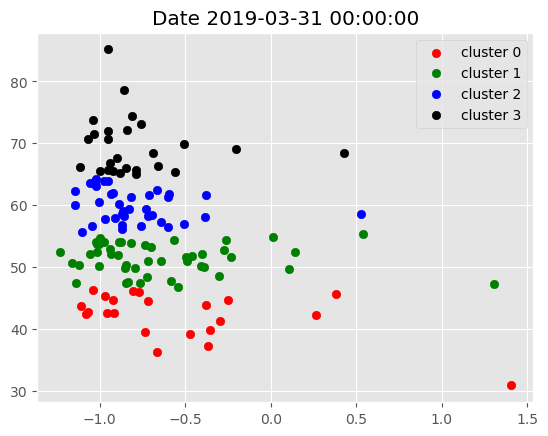

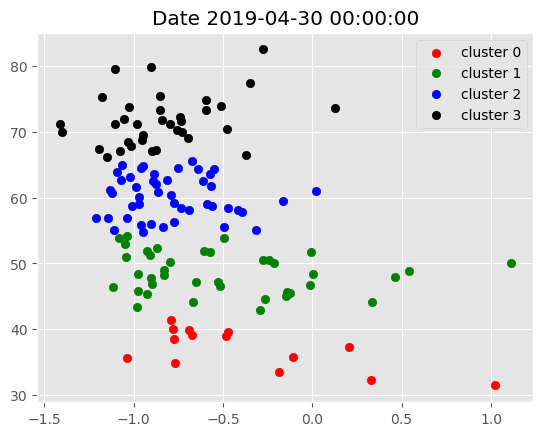

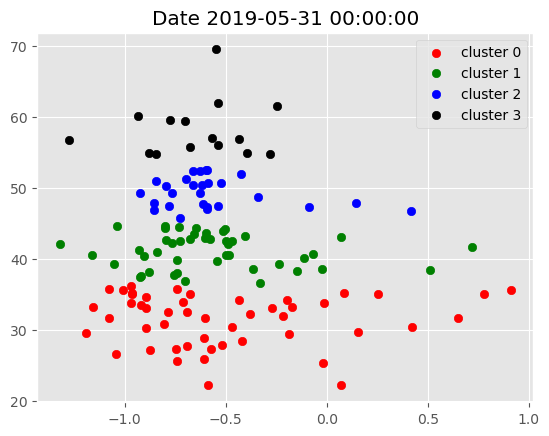

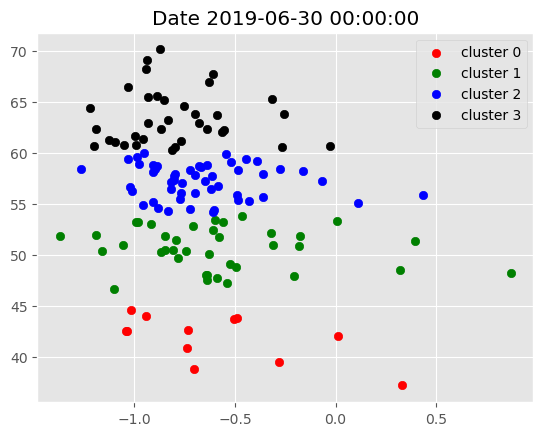

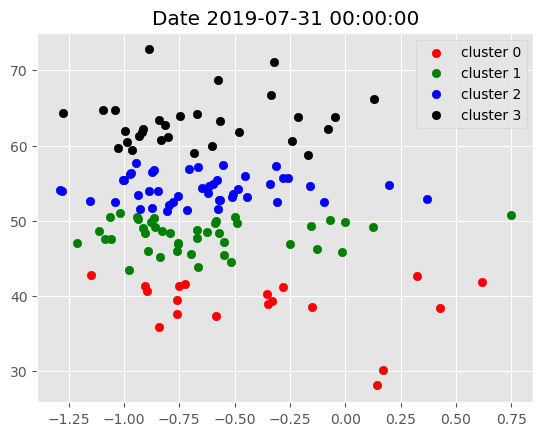

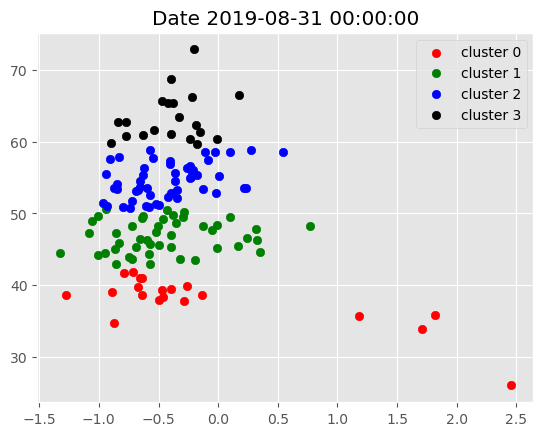

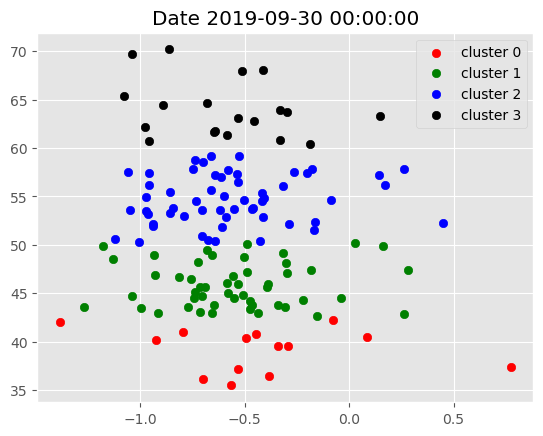

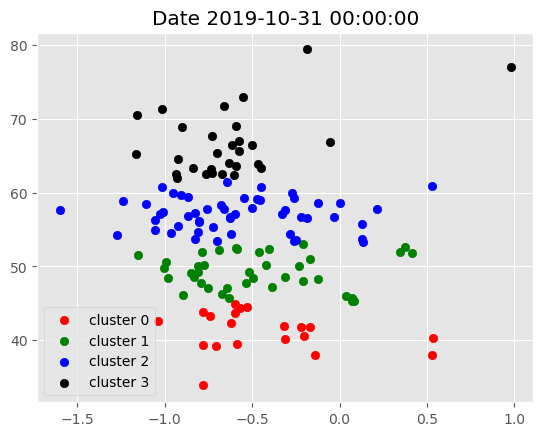

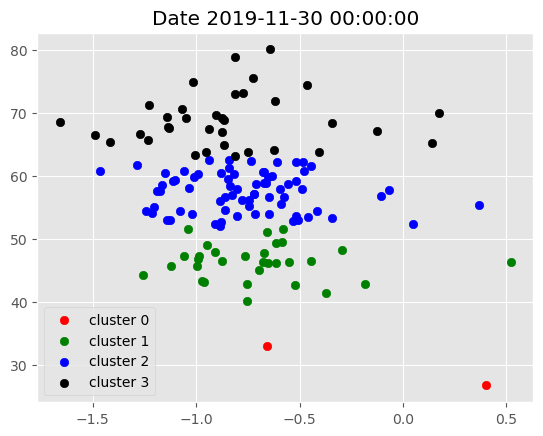

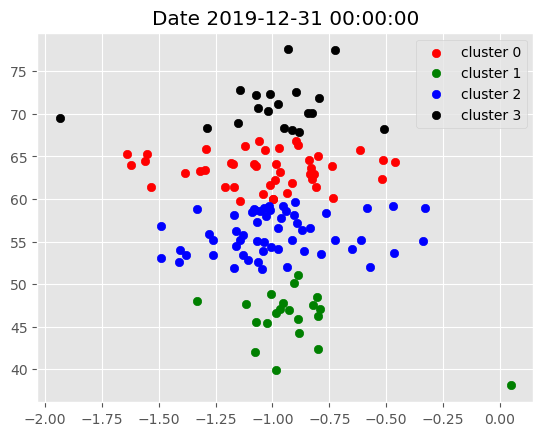

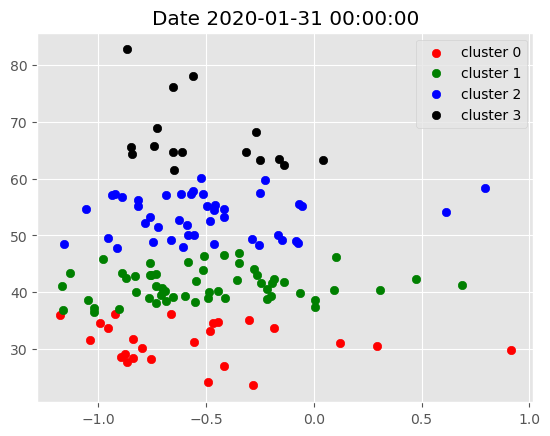

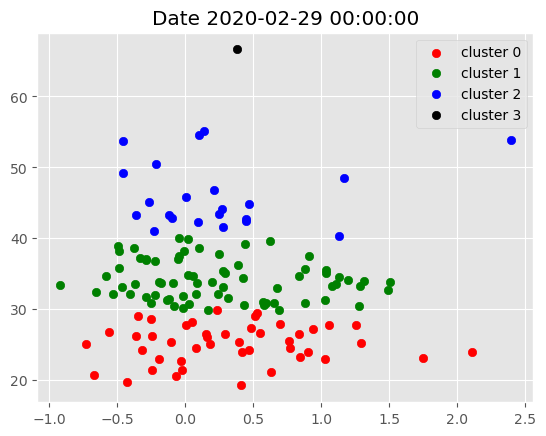

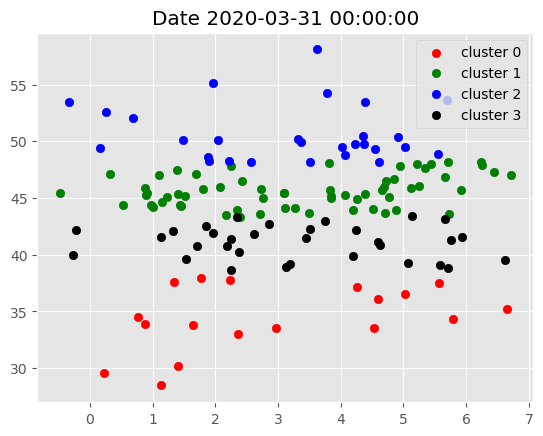

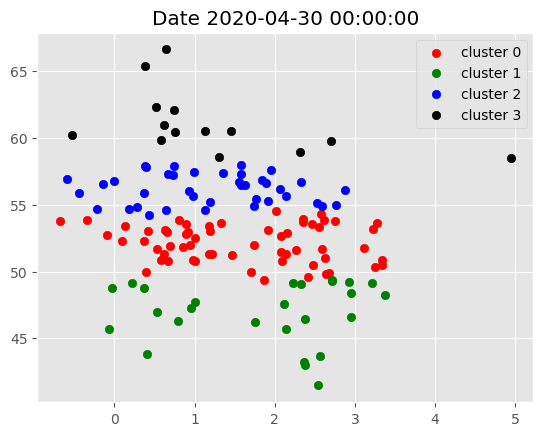

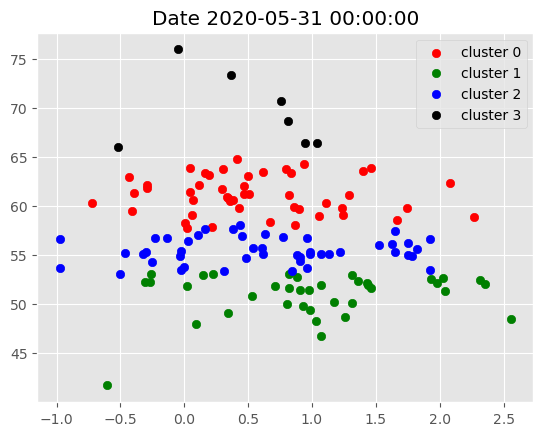

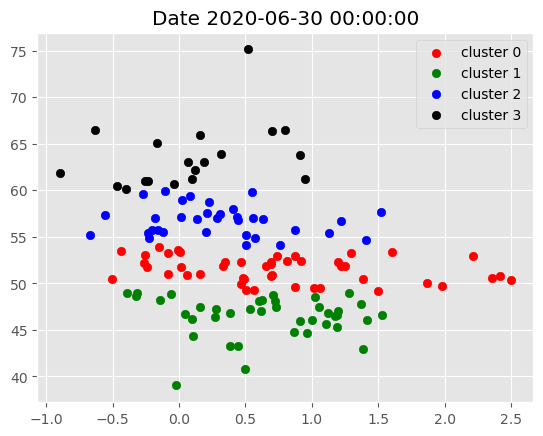

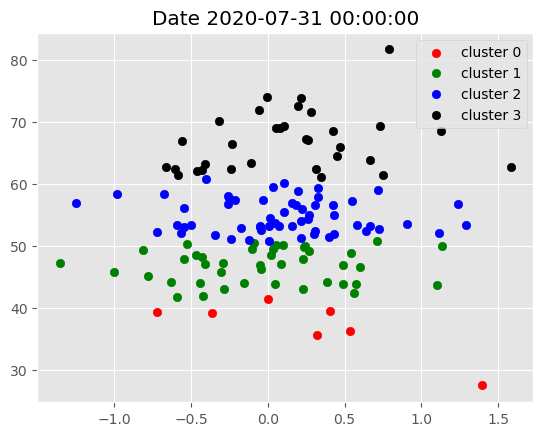

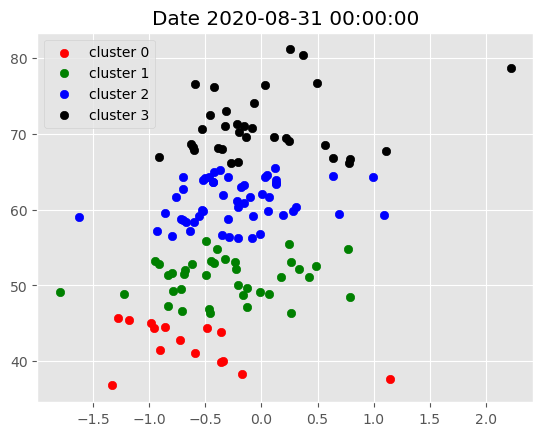

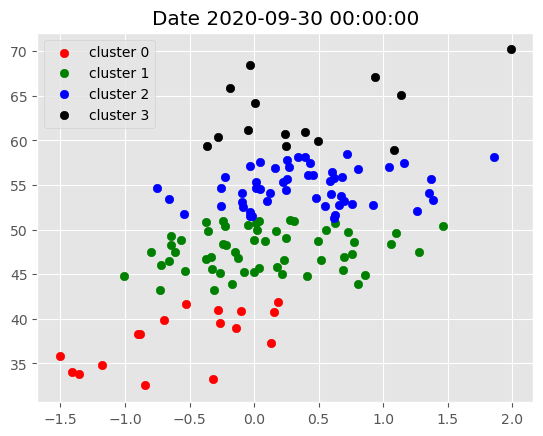

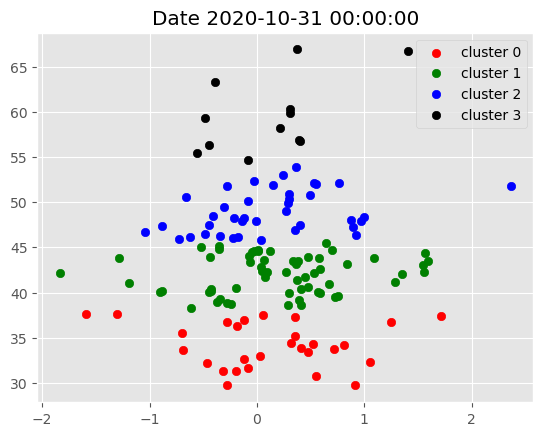

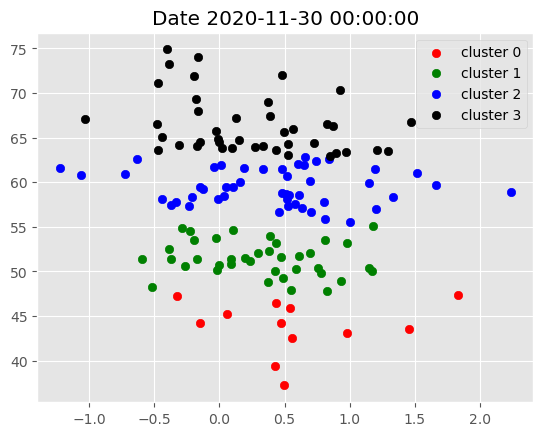

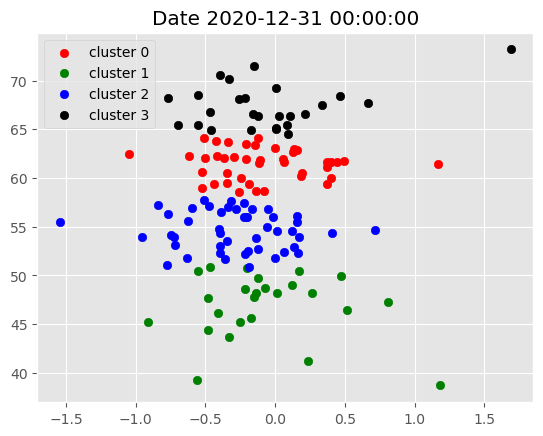

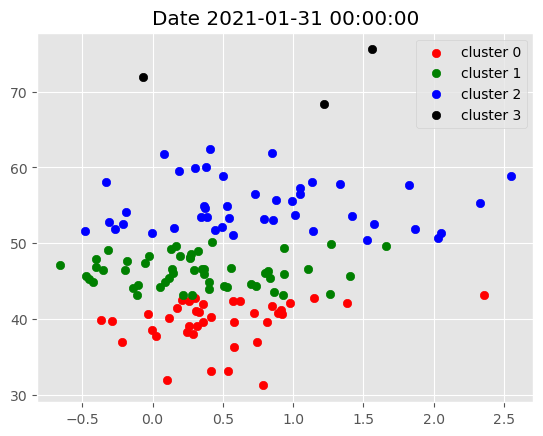

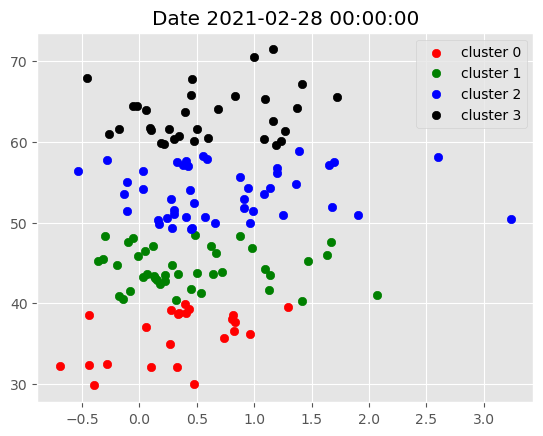

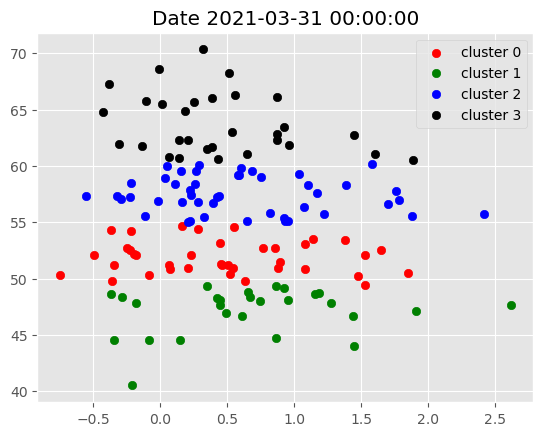

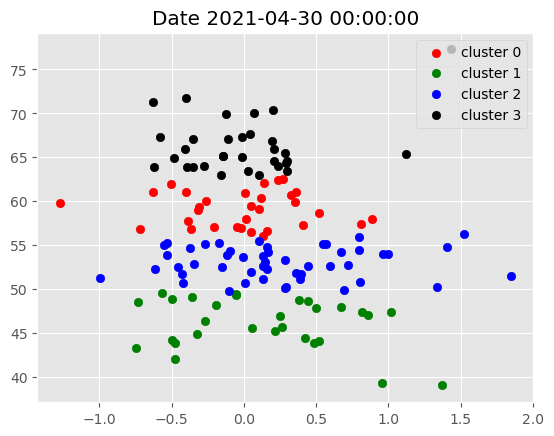

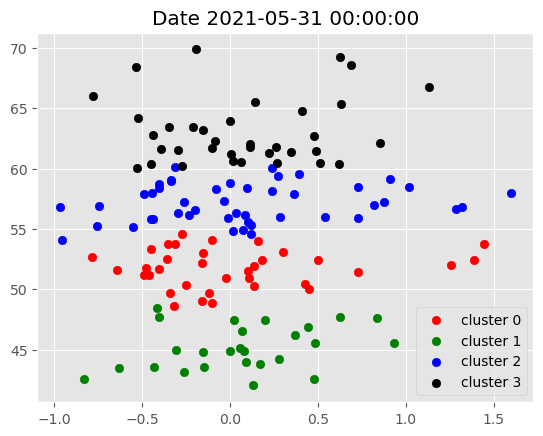

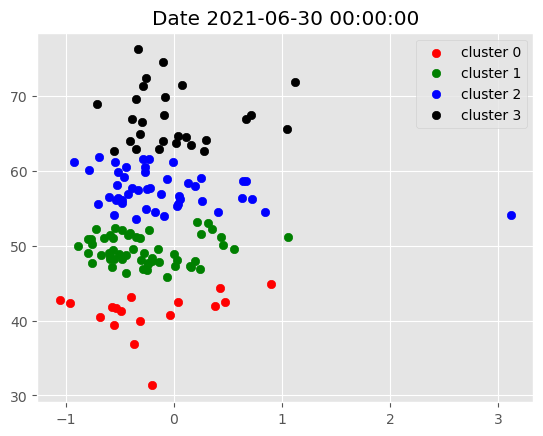

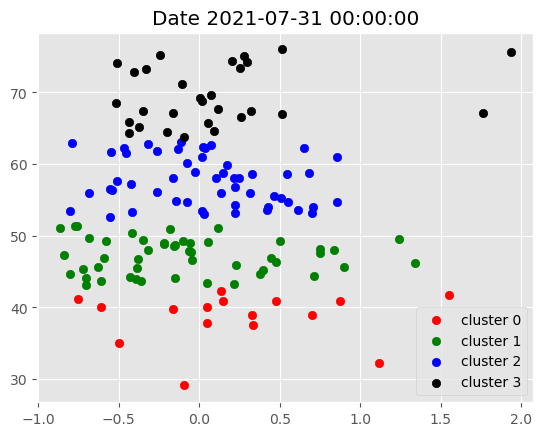

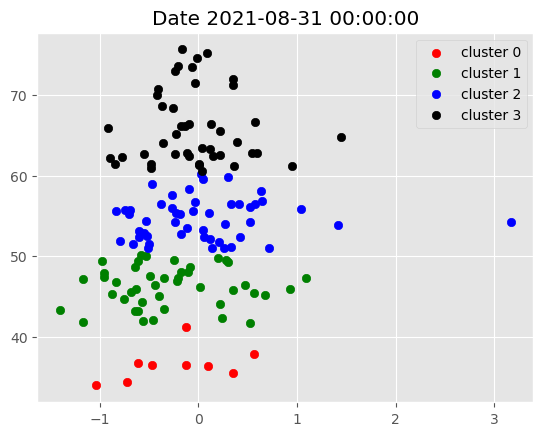

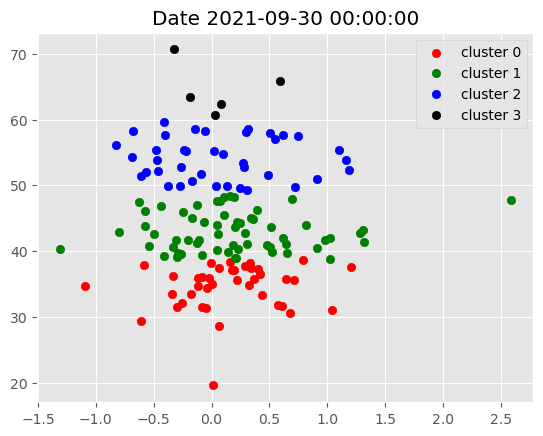

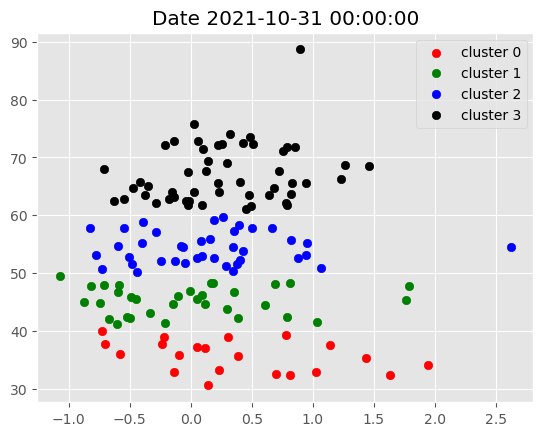

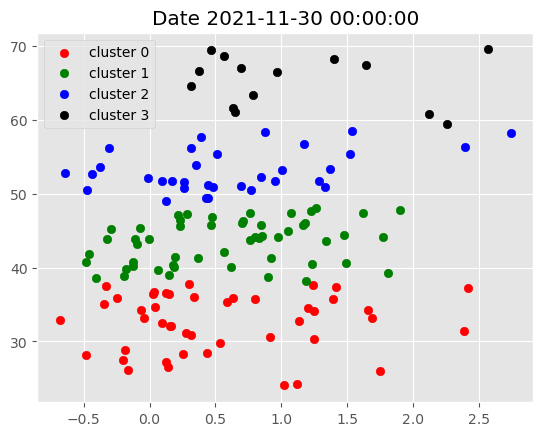

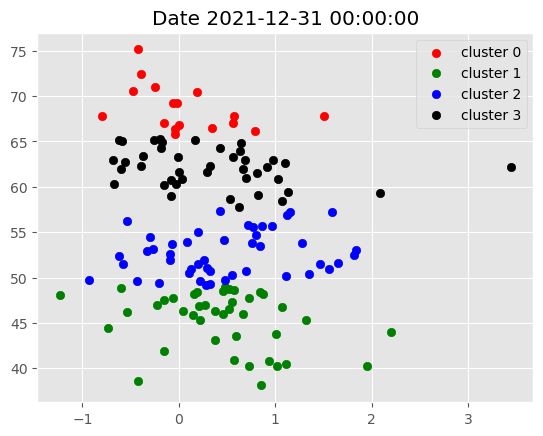

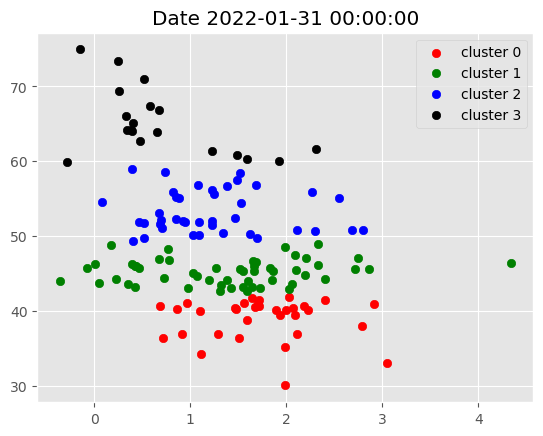

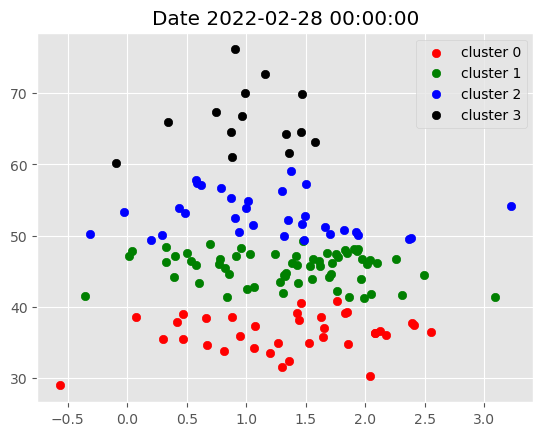

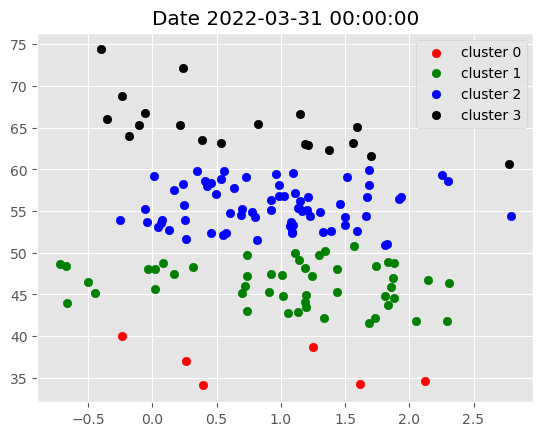

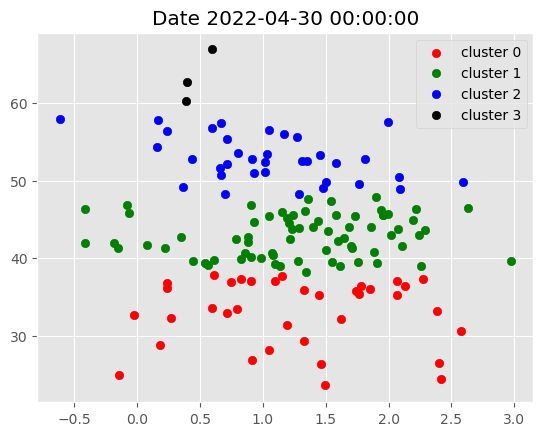

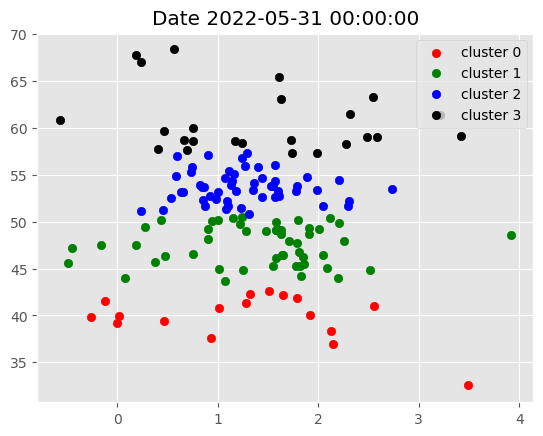

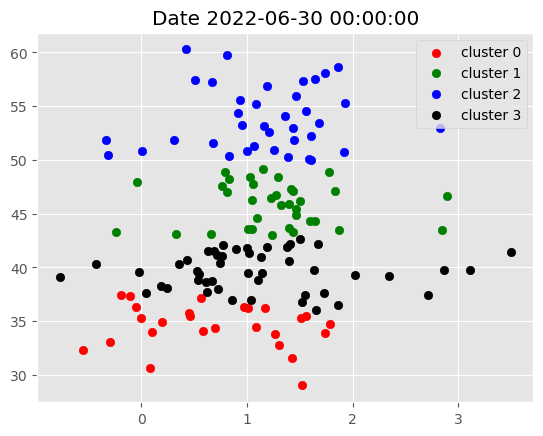

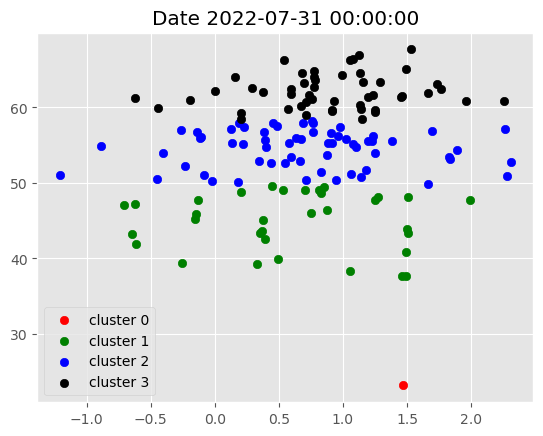

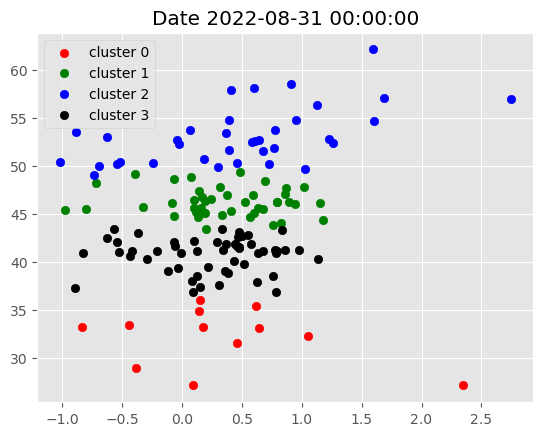

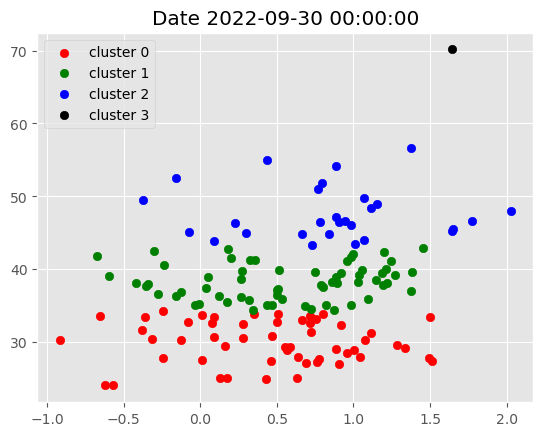

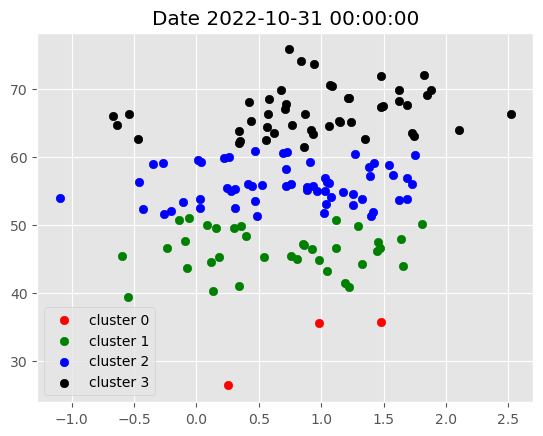

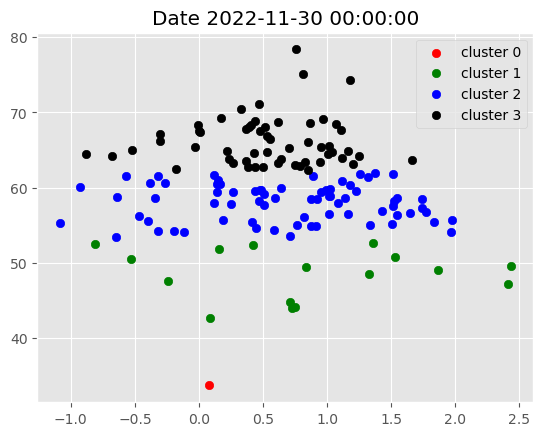

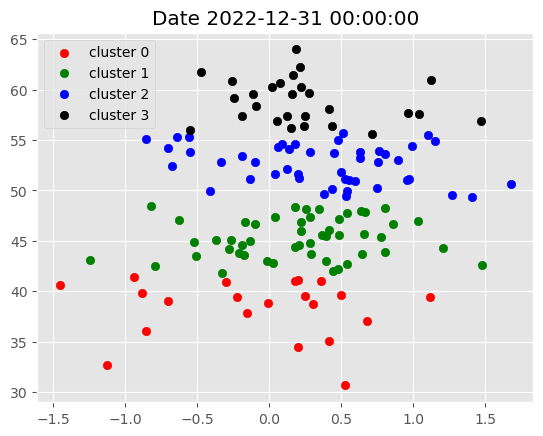

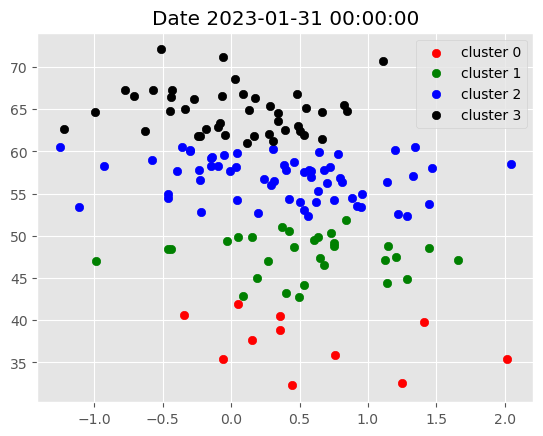

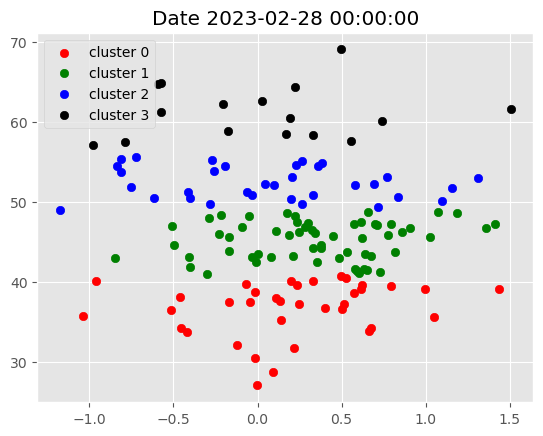

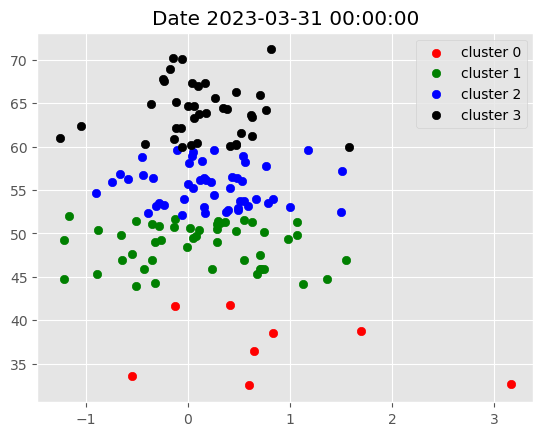

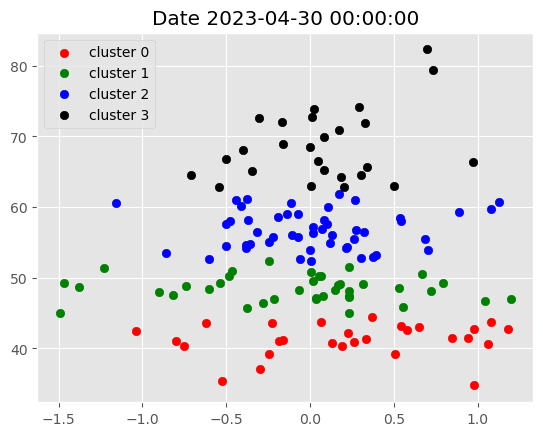

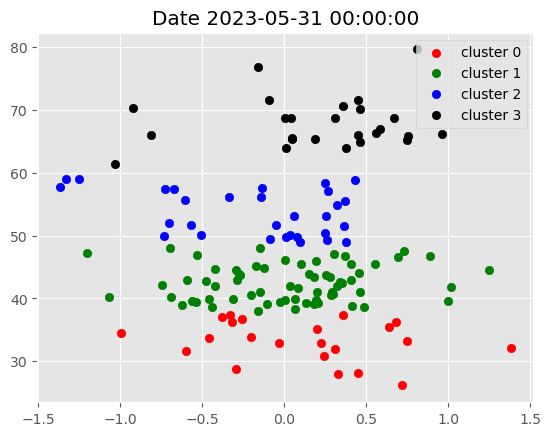

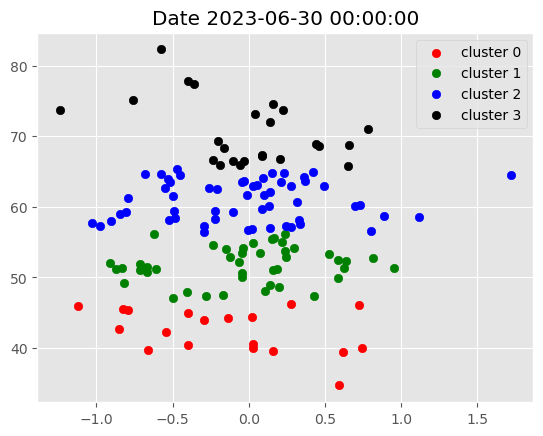

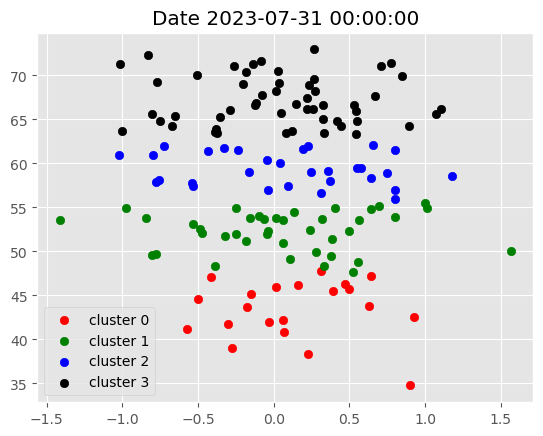

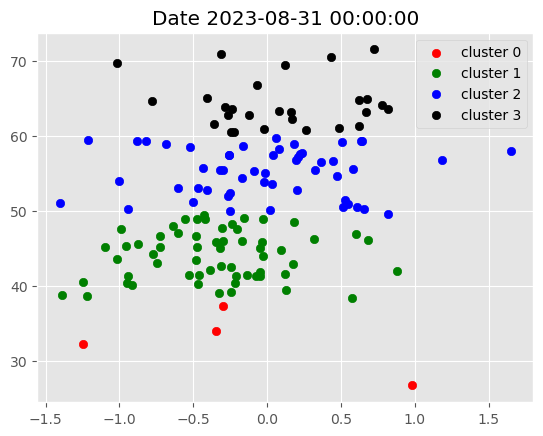

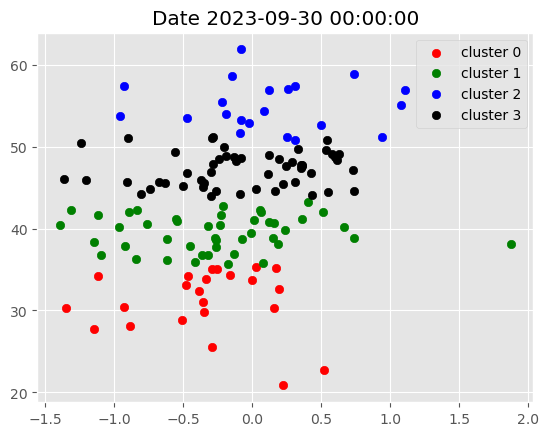

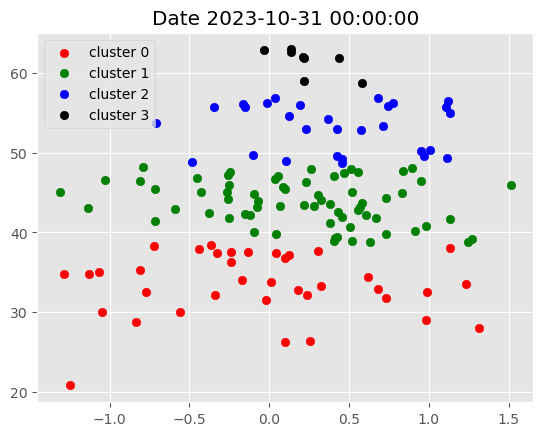

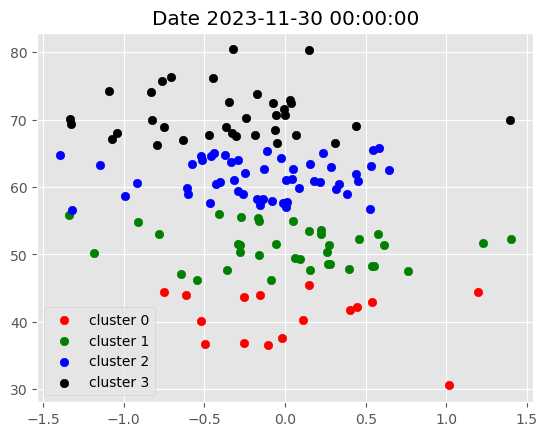

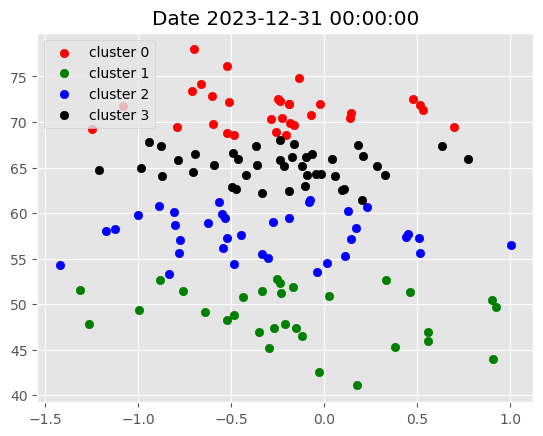

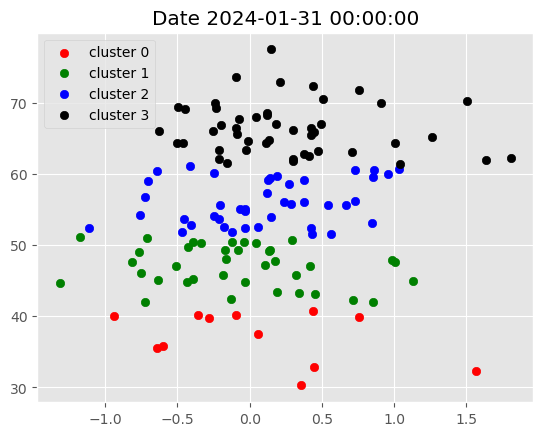

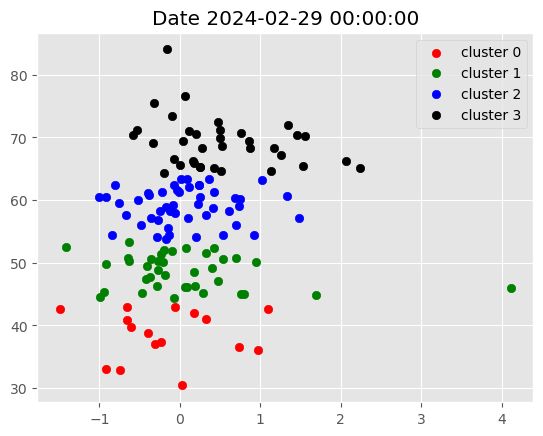

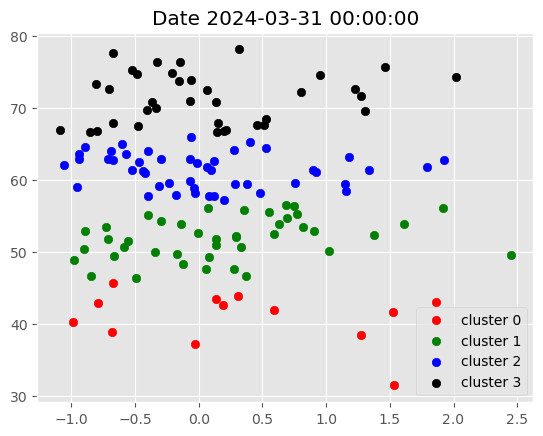

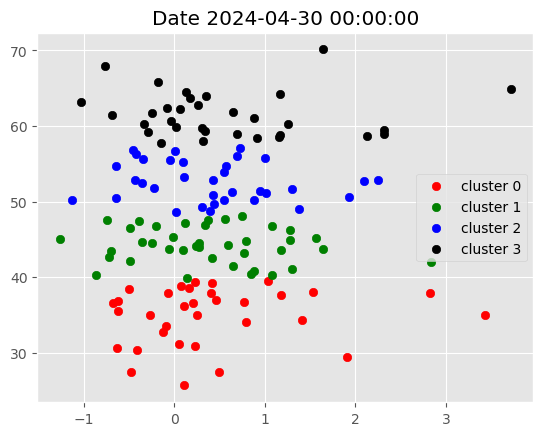

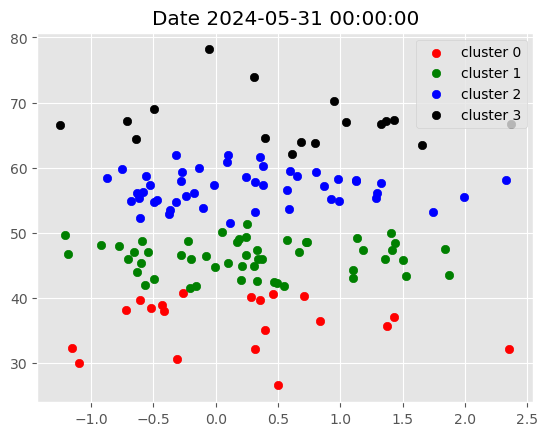

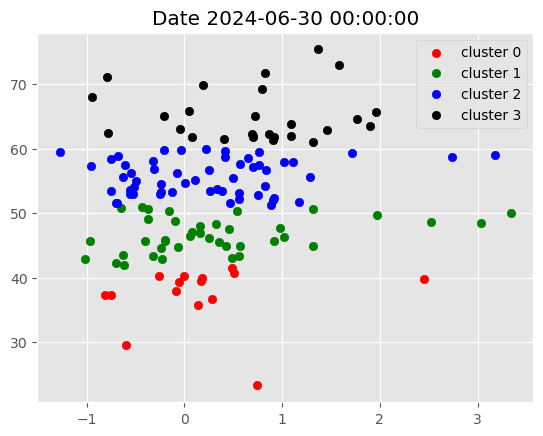

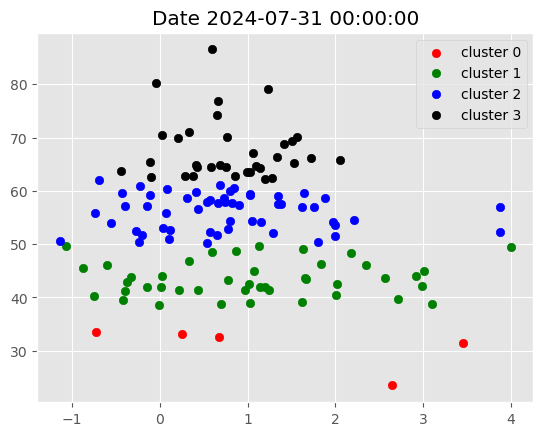

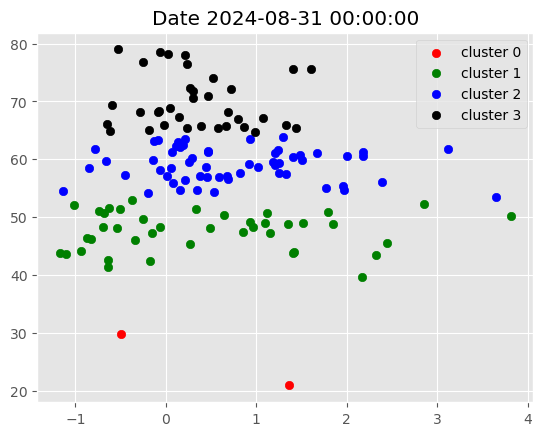

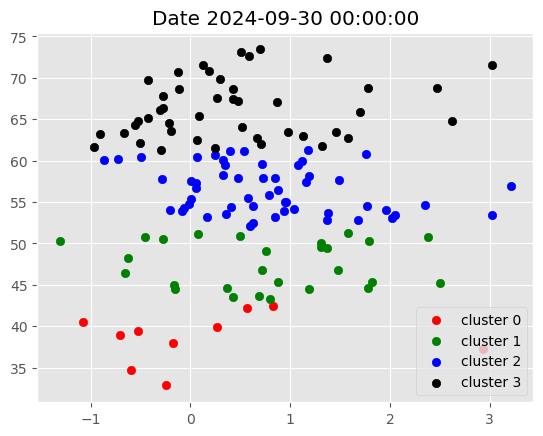

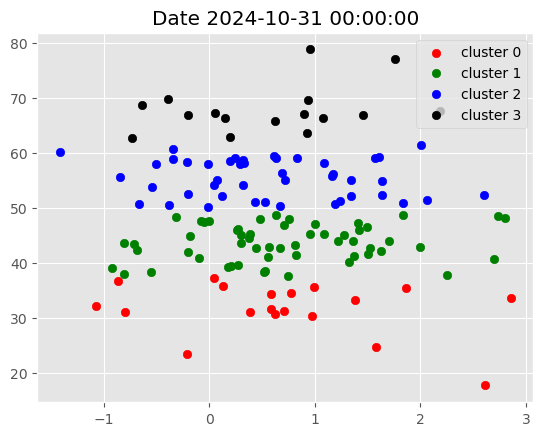

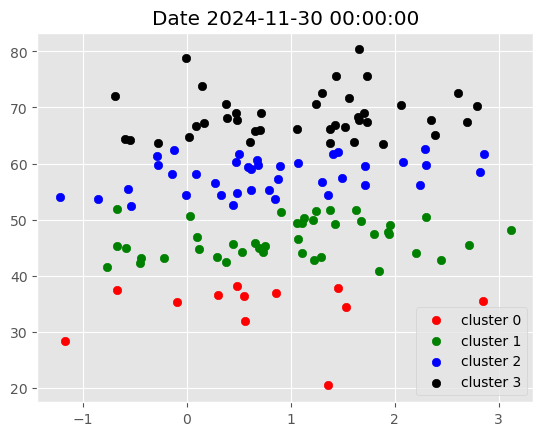

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [12]:
# Apply pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
"""
For each month select assets based on the cluster and form a portfolio based on
Efficient Frontier max sharpe ratio optimization
"""

filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-01-01': ['AAPL',
  'ACN',
  'ADP',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EXPE',
  'FCX',
  'GILD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'JPM',
  'LMT',
  'MCK',
  'META',
  'MS',
  'MU',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'TMUS',
  'ULTA',
  'UPS',
  'VLO',
  'WFC'],
 '2019-02-01': ['ADI',
  'ADSK',
  'AMAT',
  'AMD',
  'AMT',
  'AVGO',
  'BA',
  'BDX',
  'C',
  'CHTR',
  'CMG',
  'CSCO',
  'DG',
  'DHR',
  'DLTR',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'IBM',
  'LRCX',
  'LUV',
  'MA',
  'MCK',
  'MDLZ',
  'META',
  'MGM',
  'NKE',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SBUX',
  'SHW',
  'TJX',
  'USB',
  'VLO',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  '

In [17]:
# Defining the portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                     frequency=252)
    cov = risk_models.sample_cov(prices=prices,
                                frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound, .1),
                          solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [25]:
# Loading real-time data for the listed stocks

stocks = data.index.get_level_values('ticker').unique().tolist()

prices_df = yf.download(tickers=stocks,
                    start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])

[*********************100%***********************]  152 of 152 completed


In [41]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"


,Strategy Return
date,
2019-01-02,0.008220
2019-01-03,-0.021788
2019-01-04,0.036752
2019-01-07,0.008792
2019-01-08,0.007485
...,...
2024-11-22,0.007286
2024-11-25,-0.001572
2024-11-26,0.007388


<Axes: xlabel='Date'>

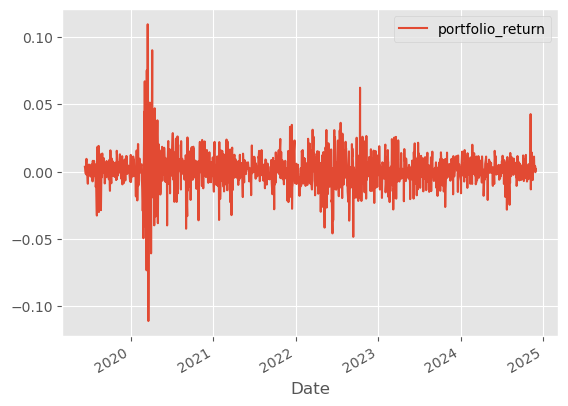

In [31]:
portfolio_df.plot()

In [43]:
# Visualize portfolio returns and compare to SP500 returns

spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,"(SPY Buy&Hold, SPY)"
2019-01-02,0.008220,0.001040
2019-01-03,-0.021788,-0.024152
2019-01-04,0.036752,0.032947
2019-01-07,0.008792,0.007854
2019-01-08,0.007485,0.009352
...,...,...
2024-11-22,0.007286,0.003095
2024-11-25,-0.001572,0.003386
2024-11-26,0.007388,0.005208
2024-11-27,-0.000020,-0.003035


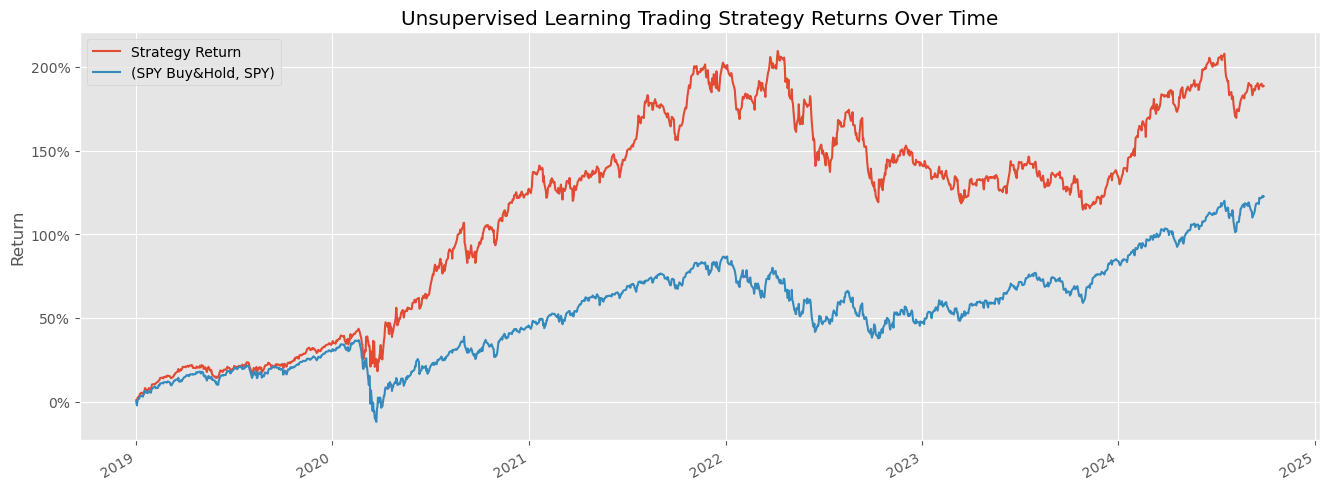

In [44]:
import matplotlib.ticker as mtick 

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()